In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterable, Literal, Optional, Union, Any, List, Dict, Tuple
from itertools import count, pairwise
import openseespy.opensees as ops
import opstool as opst

import ops_utilities as opsu
from ops_utilities.pre import AutoTransf, ReBarHub, ConcHub, Mander

from AnalysisLibraries import StaticAnalysis

In [2]:
# Set unit
# UNIT = opst.pre.UnitSystem(length = "m",force = "kn",time = "sec")
UNIT = opst.pre.UnitSystem(length = "mm",force = "n",time = "sec")

# Set constant
g = 9.80665 * (UNIT.m / UNIT.sec ** 2)
Ubig = 1.e10
Usmall = 1.e-10

# Set data path
data_path = './OutData'
os.makedirs(data_path, exist_ok=True)
opst.post.set_odb_path(data_path) # set opstool ODB path

In [3]:
class ModelCreator:
    
    # ---------- ----------
    # 材料参数
    # ---------- ----------
    concrete = 'C40'
    steel_bar = 'HRB400'
    
    # 混凝土材料本构参数
    Ec: float # 弹性模量
    
    fc: float # 保护层 - 混凝土强度
    ec: float # 保护层 - 混凝土最大强度对应的应变
    eu: float # 保护层 - 混凝土最大应变

    fcc: float # 核心 - 混凝土强度
    ecc: float # 核心 - 混凝土最大强度对应的应变
    ecu: float # 核心 - 混凝土最大应变
    
    # 钢筋材料本构参数
    fy: float # 钢筋强度
    Es: float # 钢筋弹性模量
    
    # ---------- ----------
    # 截面参数
    # ---------- ----------
    R = 0.6 * UNIT.m # 截面半径
    r = 0.2 * UNIT.m # 内孔半径
    cover = 4. * UNIT.cm  # 保护层厚度
    bar_dia = 28. * UNIT.mm  # 钢筋直径
    
    SEC: opst.pre.section.FiberSecMesh
    sec_props: Dict[str, Any]
    
    # ---------- ----------
    # 模型几何参数
    # ---------- ----------
    H = 3.2 * UNIT.m # 模型高度

    @classmethod
    def _mat(cls, coverTag: int, coreTag: int, barTag: int, info: bool = True):
        
        # 获取配筋率
        rho = cls.sec_props['rho_rebar']
        
        # 混凝土本构数据
        cls.fc, cls.ec, cls.eu = ConcHub.get_fcuk(cls.concrete) * UNIT.mpa, 0.002, 0.0033
        cls.fcc, cls.ecc, cls.ecu = Mander.circular(
            hoop='Circular',
            coverThick=cls.cover, d=cls.R * 2., roucc=rho,
            s=0.1 * UNIT.m, ds=0.014 * UNIT.m,
            fco=cls.fc, fyh=400 * UNIT.mpa)
        cls.Ec = ConcHub.get_Ec(cls.concrete) * UNIT.mpa
        
        # 钢筋本构数据
        cls.fy, cls.Es = ReBarHub.get_fyk(cls.steel_bar) * UNIT.mpa, ReBarHub.get_Es(cls.steel_bar) * UNIT.mpa
        
        # 定义材料
        ops.uniaxialMaterial('Concrete04', coverTag, -cls.fc, -cls.ec, -cls.eu, cls.Ec)
        ops.uniaxialMaterial('Concrete04', coreTag, -cls.fcc, -cls.ecc, -cls.ecu, cls.Ec)
        ops.uniaxialMaterial('Steel02', barTag, cls.fy, cls.Es, 0.01)
        
        # 打印
        if info:
            print(f'保护层：fc={cls.fc:.3f}, ec={cls.ec:.3f}, eu={cls.eu:.3f}, Ec={cls.Ec:.3f}')
            print(f'核心：fcc={cls.fcc:.3f}, ecc={cls.ecc:.3f}, ecu={cls.ecu:.3f}, Ec={cls.Ec:.3f}')
            print(f'钢筋：fy={cls.fy:.3f}, Es={cls.Es:.3f}')

    @classmethod
    def circle_sec(
        cls,
        coverTag: int, coreTag: int, barTag: int,
        secTag: int,
        info: bool = True):

        # 轮廓线
        cover_outline = opst.pre.section.create_circle_points(xo=[0, 0], radius=cls.R - cls.cover, n_sub=30) # 保护层轮廓线
        inner_outline = opst.pre.section.create_circle_points(xo=[0, 0], radius=cls.r, n_sub=30) # 内孔轮廓线
        # 生成几何形状
        cover_geo = opst.pre.section.create_circle_patch(xo=[0, 0], radius=cls.R, holes=[cover_outline], n_sub=30) # 保护层几何形状
        core_geo = opst.pre.section.create_circle_patch(xo=[0, 0], radius=cls.R - cls.cover, holes=[inner_outline], n_sub=30) # 核心几何形状

        # 截面网格
        cls.SEC = opst.pre.section.FiberSecMesh(sec_name='Column Section')
        cls.SEC.add_patch_group({"Cover": cover_geo, "Core": core_geo})
        cls.SEC.set_mesh_color({"Cover": "#ffa756", "Core": "#40a368"})
        
        # 明确材料编号
        cls.SEC.set_ops_mat_tag({"Cover": coverTag, "Core": coreTag})
        cls.SEC.add_rebar_circle(
            xo=[0, 0], radius=cls.R - cls.cover - cls.bar_dia / 2.,
            dia=cls.bar_dia, n=21,
            ops_mat_tag=barTag, color='red')
        cls.SEC.add_rebar_circle(
            xo=[0, 0], radius=cls.r + cls.cover + cls.bar_dia / 2.,
            dia=cls.bar_dia, n=11,
            ops_mat_tag=barTag, color='red')

        # 生成网格
        cls.SEC.mesh()
        cls.SEC.centring()

        # 信息打印
        cls.sec_props = cls.SEC.get_sec_props(display_results=info) # 截面信息
        if info:
            cls.SEC.view(fill=True, show_legend=True)
            plt.show()
        
        # 定义材料
        cls._mat(coverTag, coreTag, barTag, info)

        # 定义截面
        cls.SEC.to_opspy_cmds(secTag=secTag, G=100. * UNIT.gpa)
    


In [4]:
tagLib = {
    'cover': 1,
    'core': 2,
    'rebar': 3,
    'section': 10, # 截面编号
    'npTag': 1, # 积分点
    'transfTag': 1, # 局部坐标转换编号
    'ctrl_node': 1001, # 控制节点
    'key_ele': 101, # 关键单元
    'tsTag': 1, # 时间序列编号
    'patternTag': 1, # 荷载模式编号
    }

ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6)

ModelCreator.circle_sec(
    coverTag=tagLib['cover'], coreTag=tagLib['core'], barTag=tagLib['rebar'],
    secTag=tagLib['section'],
    info=False)

ops.beamIntegration('Legendre', tagLib['npTag'], tagLib['section'], 5) # 积分点
ops.geomTransf('PDelta', tagLib['transfTag'], *(-1, 0, 0)) # 局部坐标转换

# 计数器
node_count = count(1) # 节点编号起点
ele_count = count(1) # 单元编号起点

# 节点库
node_hub = {
    next(node_count): (0., 0., 0. * UNIT.m),
    next(node_count): (0., 0., 0.2 * UNIT.m),
    next(node_count): (0., 0., 0.4 * UNIT.m),
    next(node_count): (0., 0., 0.6 * UNIT.m),
    next(node_count): (0., 0., 1.0 * UNIT.m),
    next(node_count): (0., 0., 1.5 * UNIT.m),
    next(node_count): (0., 0., 2.0 * UNIT.m),
    next(node_count): (0., 0., 2.5 * UNIT.m),
    next(node_count): (0., 0., 3.5 * UNIT.m),
    tagLib['ctrl_node']: (0., 0., ModelCreator.H),
    }

# 创建节点
for k, v in node_hub.items():
    ops.node(k, *v)
    # print(f'nodeTag: {k}, coord: {v}')

# 单元连接
ele_links = list(pairwise(node_hub.keys()))
# 创建单元
ops.element('dispBeamColumn', tagLib['key_ele'], *(ele_links[0]), tagLib['transfTag'], tagLib['npTag'])
for l in ele_links[1:]:
    ops.element('dispBeamColumn', next(ele_count), *l, tagLib['transfTag'], tagLib['npTag'])

# 约束
ops.fixZ(0., 1, 1, 1, 1, 1, 1)

OPSTOOL™ :: The section Column Section has been successfully meshed!

In [5]:
# ops.node(90001, 1000.0, 0.0, 0.0)
# ops.node(90002, -1000.0, 0.0, 0.0)
# ops.node(90003, 0.0, 1000.0, 0.0)
# ops.node(90004, 0.0, -1000.0, 0.0)

# opst.vis.plotly.plot_model(show_local_axes=True)

In [6]:
# Case
CASE = 1

# Create data base
opst.post.set_odb_format(odb_format="nc") # opstool.version >= 1.0.25
ODB = opst.post.CreateODB(odb_tag=CASE, fiber_ele_tags="ALL", zlib=True) # zlib need opstool.version >= 1.0.25

# Linear timeSeries
ops.timeSeries("Linear", tagLib['tsTag'])

# 荷载模式
ops.loadConst('-time', 0.0) # 时间置零后一定要有 pattern
ops.pattern("Plain", tagLib['patternTag'], tagLib['tsTag'])
ops.load(tagLib['ctrl_node'], *(0., 1., 0., 0., 0., 0.))


# Displacement path
# disp_path = np.array([
#     0.,
#     0.01, -0.01,
#     0.02, -0.02,
#     0.03, -0.03,
#     0.04, -0.04,
#     0.06, -0.06,
#     0.08, -0.08,
#     0.10, -0.10,
#     0.
#     ]) * UNIT.m
disp_path = [0.1 * UNIT.m]


# Analysis
cycle = StaticAnalysis(pattern_tag=tagLib['patternTag'], ODB=ODB)
disp, force = cycle.analyze(
    ctrl_node=tagLib['ctrl_node'],dof=2,
    targets=disp_path, max_step=0.002 * UNIT.m,
    )

"# ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- -----"
# Save data base
ODB.save_response()

🚀 OPSTOOL::SmartAnalyze: 100%|██████████| 50/50 [00:01<00:00, 45.31 step/s]

Note: OpenSees LogFile has been generated in .SmartAnalyze-OpenSees.log.
>>> 🎉 OPSTOOL::SmartAnalyze:: Successfully finished! Time consumption: 1.120 s. 🎉


OPSTOOL™ ::  All responses data with _odb_tag = 1 saved in ./OutData\RespStepData-1.odb!

In [7]:
SMS = opsu.post.SecMatStates(odb_tag=CASE, ele_tag=tagLib['key_ele'], integ=1)

# 钢筋应变状态
eps_bar_1 = ModelCreator.fy / ModelCreator.Es # 第一阶段：钢筋屈服对应应变
eps_bar_2 = 0.015 # 第二阶段：钢筋应变硬化对应应变
eps_bar_3 = 0.1* 0.55 # 第三阶段：钢筋极限应变的0.55倍
eps_bar_4 = 0.1 # 第四阶段：钢筋极限应变

# 核心混凝土应变状态
eps_core_1 = eps_bar_1 # 第一阶段屈服：由钢筋决定
eps_core_2 = ModelCreator.eu # 第二阶段：混凝土限制应变
eps_core_3 = ModelCreator.ecu * 0.75 # 第三阶段：混凝土屈服
eps_core_4 = ModelCreator.ecu # 第四阶段：核心混凝土极限应变

# 打印
print(f"钢筋应变状态：{eps_bar_1:.4f}, {eps_bar_2:.4f}, {eps_bar_3:.4f}, {eps_bar_4:.4f}")
print(f"核心混凝土应变状态：{eps_core_1:.4f}, {eps_core_2:.4f}, {eps_core_3:.4f}, {eps_core_4:.4f}")

# 仅判断钢筋屈服
yield_step = SMS.get_steps_mat(mat_tag=tagLib['rebar'], data_type='Strains',stages=eps_bar_1)
# 仅判断单一材料
rebar_damage = SMS.get_steps_mat(mat_tag=tagLib['rebar'], data_type='Strains',stages=(eps_bar_1, eps_bar_2, eps_bar_3, eps_bar_4))
core_damage = SMS.get_steps_mat(mat_tag=tagLib['core'], data_type='Strains',stages=(-eps_bar_1, -eps_core_2, -eps_core_3, -eps_core_4))
# core_damage = SMS.get_steps(mat_tag=tagLib['core'], data_type='strain',stages=(-0.2, -0.3, -0.4, -0.5)) # 全是None
print(f"钢筋损伤状态：{rebar_damage}")
print(f"核心损伤状态：{core_damage}")

# 多阶段损伤状态判断
sec_damage = SMS.get_combined_steps_mat(
    mat_config={
        tagLib['rebar']: (eps_bar_1, eps_bar_2, eps_bar_3, eps_bar_4),
        tagLib['core']: (-eps_bar_1, -eps_core_2, -eps_core_3, -eps_core_4),
        # tagLib['rebar']: (0.2, 0.3, 0.4, 0.5),
        # tagLib['core']: (-0.2, -0.3, -0.4, -0.5),
        
        },
    data_type='Strains',
    warn=False
    )
print(f"多阶段损伤状态：{sec_damage}")

OPSTOOL™ ::  Loading FiberSection response data from ./OutData\RespStepData-1.odb ...


 # 导入的原数据：
<xarray.DatasetView> Size: 10MB
Dimensions:      (time: 51, eleTags: 9, secPoints: 5, fiberPoints: 496, DOFs: 4)
Coordinates:
  * time         (time) float32 204B 0.0 1.633e+05 ... 1.108e+06 1.105e+06
  * eleTags      (eleTags) int64 72B 1 2 3 4 5 6 7 8 101
  * secPoints    (secPoints) int64 40B 1 2 3 4 5
  * fiberPoints  (fiberPoints) int64 4kB 1 2 3 4 5 6 ... 491 492 493 494 495 496
  * DOFs         (DOFs) <U2 32B 'P' 'Mz' 'My' 'T'
Data variables:
    Stresses     (time, eleTags, secPoints, fiberPoints) float32 5MB 0.0 ... ...
    Strains      (time, eleTags, secPoints, fiberPoints) float32 5MB 0.0 ... ...
    secDefo      (time, eleTags, secPoints, DOFs) float32 37kB 0.0 -0.0 ... 0.0
    secForce     (time, eleTags, secPoints, DOFs) float32 37kB 0.0 0.0 ... 0.0
    ys           (eleTags, secPoints, fiberPoints) float64 179kB -406.5 ... 2...
    zs           (eleTags, secPoints, fiberPoints) float64 179kB -420.4 ... -...
    areas        (eleTags, secPoints, fiberPoints) 

⚠️  UserWarning: Stages is not monotonically increasing.                 
Automatically sorted to ['-0.0100', '-0.0075', '-0.0033', '-0.0020']. 
(C:\Users\Jinger\AppData\Local\Temp\ipykernel_22760\787794263.py:23)

钢筋损伤状态：[0, 5, 14, 32, 46]
核心损伤状态：[0, 11, 13, 21, 29]
多阶段损伤状态：[0, 5, 13, 21, 29]


In [8]:
rebar_stress = SMS.get_steps_mat(mat_tag=tagLib['rebar'], data_type='Stresses',stages=ModelCreator.fy * UNIT.mpa)
core_stress = SMS.get_steps_mat(mat_tag=tagLib['core'], data_type='Stresses',stages=-ModelCreator.fcc * UNIT.mpa)
print(f'钢筋 屈服应力 分析步：{rebar_stress}')
print(f'核心 峰值应力 分析步：{core_stress}')

 Ops! Stages: ['-46.7625'] not reachable. 

钢筋 屈服应力 分析步：[0, 5]
核心 峰值应力 分析步：[0, None]


In [9]:
filtered_ds = list(filter(None, sec_damage)) # 过滤掉 None 值，开头的 0 也会被过滤掉
print(f'过滤 None 值：{filtered_ds}')

过滤 None 值：[5, 13, 21, 29]


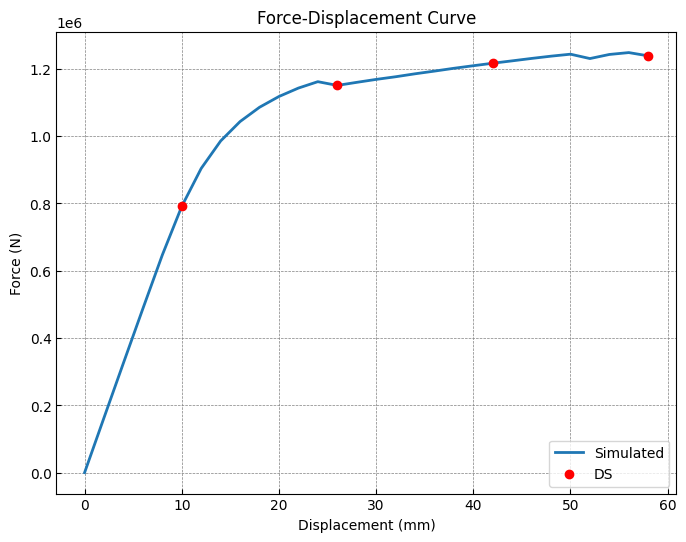

In [10]:
plt.close('all')
plt.figure(figsize=(8, 6))
plt.title('Force-Displacement Curve')
# plt.plot(disp * UNIT.mm, force * UNIT.n, linewidth=2, color="#00A2FF", label='Simulated', zorder=2)
plt.plot(disp[:filtered_ds[-1]+1] * UNIT.mm, force[:filtered_ds[-1]+1] * UNIT.n, linewidth=2, label='Simulated', zorder=2)
plt.scatter(disp[filtered_ds] * UNIT.mm, force[filtered_ds] * UNIT.n, label='DS', color='red', zorder=3) # 损伤阶段关键点
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.grid(color='gray', linestyle='--', linewidth=0.5, zorder=1)
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))
plt.show()

In [11]:
STRAINS = SMS.get_data_mat(mat_tag=tagLib['rebar'], data_type='Strains') # 所有钢筋点的数据
STRESSES = SMS.get_data_mat(mat_tag=tagLib['rebar'], data_type='Stresses') # 所有钢筋点的数据
print(f'All fiber points strain: \n')
STRESSES

All fiber points strain: 



,465,466,467,468,469,470,471,472,473,474,...,487,488,489,490,491,492,493,494,495,496
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-31.223488,-28.126740,-19.156830,-5.191796,12.401366,31.900517,51.396942,68.982201,82.934914,91.889305,...,8.133677,22.814596,40.955395,55.626907,61.225109,55.611683,40.930763,22.789963,8.118453,2.520249
2,-62.830124,-56.630562,-38.670380,-10.707650,24.520441,63.565521,102.605591,137.819138,165.759171,183.690720,...,15.977839,45.374302,81.699623,111.078773,122.289917,111.050766,81.654305,45.328976,15.949826,4.738689
3,-94.968391,-85.656349,-58.674397,-16.663719,36.263386,94.926041,153.581940,206.488770,248.456619,275.345825,...,23.433985,67.599182,122.175941,166.317795,183.163986,166.280045,122.114876,67.538109,23.396240,6.549964
4,-128.096619,-115.607292,-79.414482,-23.060999,47.936893,126.629425,205.313004,276.216614,331.268707,362.507996,...,30.731958,89.976006,163.187866,222.400955,244.993225,222.354401,163.112534,89.900658,30.685390,8.084958
5,-165.627502,-149.283463,-101.944839,-28.245462,64.600464,167.504501,270.343658,358.170837,394.173279,399.376038,...,42.075264,119.552383,215.286423,292.535980,321.441437,292.453918,215.152374,119.418327,41.992413,12.449991
6,-207.473572,-186.304962,-125.050598,-29.706839,90.393280,223.491135,352.724701,398.928467,401.594147,402.301819,...,61.193710,161.418503,285.124390,374.037842,391.014038,373.938263,284.867004,161.159454,61.033604,22.850086
7,-253.871872,-226.749390,-148.108643,-25.657110,128.615784,299.351410,398.500763,402.215240,403.469513,404.256653,...,91.232033,219.962784,369.931488,400.349823,401.384186,400.346710,369.821533,219.800781,91.131889,42.022301
8,-303.372131,-269.498444,-170.415451,-16.002895,178.576599,379.199158,402.052795,404.045044,405.590149,406.581818,...,131.613602,293.775116,399.878632,402.554840,403.186615,402.555176,399.880859,293.828644,131.647034,69.613556
9,-352.556366,-313.910004,-192.551941,-2.562860,236.900269,400.174774,403.678223,406.075806,407.977966,409.199860,...,179.383606,370.012604,402.230499,404.261261,405.026428,404.264008,402.235260,370.312683,179.658386,103.177666


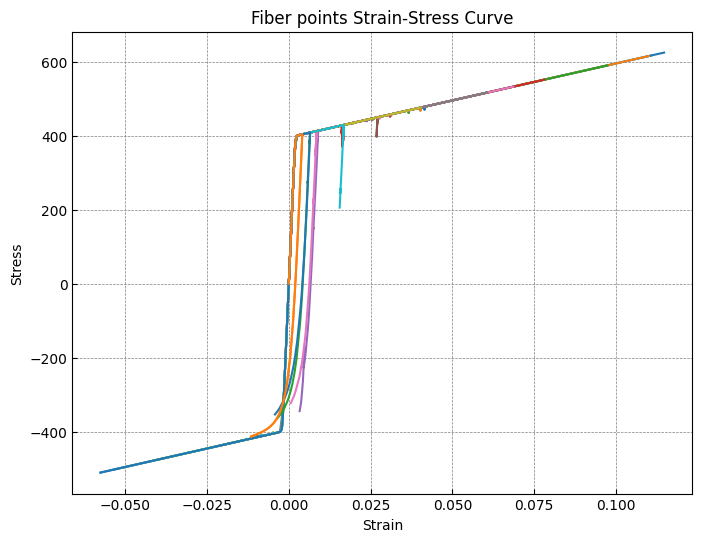

In [12]:
plt.close('all')
plt.figure(figsize=(8, 6))
plt.title(f'Fiber points Strain-Stress Curve')
plt.plot(STRAINS, STRESSES) # 整个扔到 plt 中，只要列数相同就能画
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.grid(color='gray', linestyle='--', linewidth=0.5, zorder=1)
# plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))
plt.show()

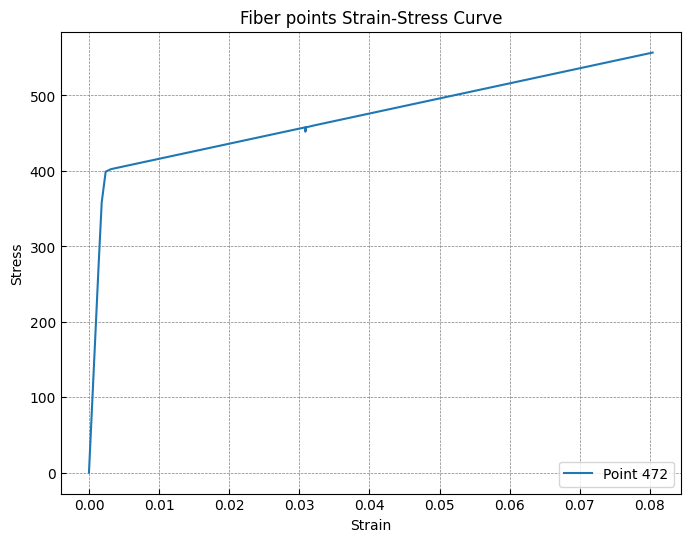

In [13]:
point = 472
STRAIN = SMS.get_data_mat(mat_tag=tagLib['rebar'], data_type='Strains', points=point)
STRESS = SMS.get_data_mat(mat_tag=tagLib['rebar'], data_type='Stresses', points=point)

plt.close('all')
plt.figure(figsize=(8, 6))
plt.title(f'Fiber points Strain-Stress Curve')
plt.plot(STRAIN, STRESS, label=f'Point {point}')
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.grid(color='gray', linestyle='--', linewidth=0.5, zorder=1)
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))
plt.show()

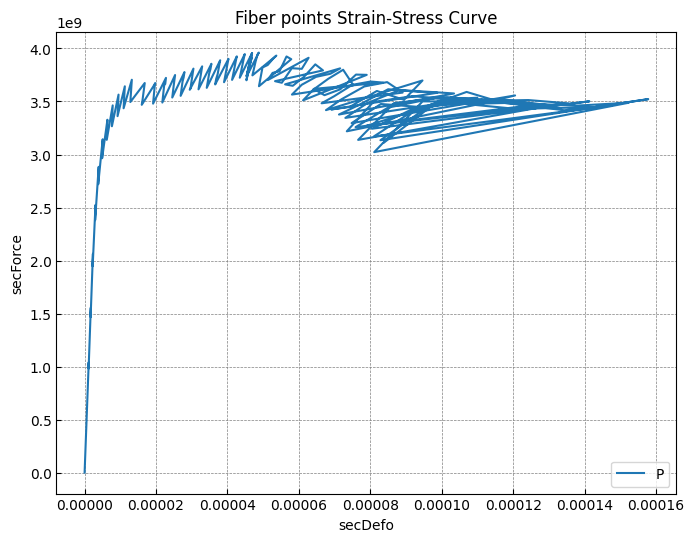

In [14]:
SEC_DEFO = SMS.get_data(data_type='secDefo', dofs='Mz')
SEC_FORCE = SMS.get_data(data_type='secForce', dofs='Mz')

plt.close('all')
plt.figure(figsize=(8, 6))
plt.title(f'Fiber points Strain-Stress Curve')
plt.plot(SEC_DEFO, SEC_FORCE, label=f'P')
plt.xlabel('secDefo')
plt.ylabel('secForce')
plt.grid(color='gray', linestyle='--', linewidth=0.5, zorder=1)
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))
plt.show()